In [6]:
import os
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def step_to_block(step, block_size=32, block_id_base=1):
    block_idx0 = step // block_size        # 0..num_blocks-1
    step_block = step % block_size         # 0..block_size-1
    block_id = block_idx0 + block_id_base
    return block_id, step_block

def load_kv_tensor(path):
    obj = torch.load(path, map_location="cpu")
    if torch.is_tensor(obj):
        return obj
    if isinstance(obj, dict):
        for key in ["k", "v", "key", "value", "K", "V"]:
            if key in obj and torch.is_tensor(obj[key]):
                return obj[key]
    raise TypeError(f"Unrecognized content in {path}: {type(obj)}")

def load_step_tensor(records_dir, sample_id, layer, kind, step,
                     block_size=32, block_id_base=1):
    block_id, step_block = step_to_block(step, block_size, block_id_base)
    fname = f"batch_{sample_id}_{block_id}_{step_block}_{layer}_{kind}_previous.pt"
    fpath = os.path.join(records_dir, fname)
    if not os.path.exists(fpath):
        raise FileNotFoundError(f"Missing file: {fpath}")
    T = load_kv_tensor(fpath)

    # Expect [seq, hidden]. If you have [1, seq, hidden], squeeze batch dim.
    if T.ndim == 3 and T.shape[0] == 1:
        T = T[0]

    if T.ndim != 2:
        raise ValueError(f"Expected 2D [seq, hidden], got shape {tuple(T.shape)} in {fpath}")

    return T.detach().float()  # float32 on CPU

def neighbor_step_similarity_heatmap(records_dir, sample_id, layer, kind="k",
                                     total_steps=128, block_size=32, block_id_base=1):
    prev = load_step_tensor(records_dir, sample_id, layer, kind, step=0,
                            block_size=block_size, block_id_base=block_id_base)
    seq_len, hidden = prev.shape

    sims = torch.empty((total_steps - 1, seq_len), dtype=torch.float32)  # [steps-1, seq]

    for step in range(1, total_steps):
        cur = load_step_tensor(records_dir, sample_id, layer, kind, step,
                               block_size=block_size, block_id_base=block_id_base)

        if cur.shape != prev.shape:
            raise ValueError(f"Shape mismatch at step {step}: {cur.shape} vs {prev.shape}")

        # cosine similarity per token position (dim=hidden)
        sims[step - 1] = F.cosine_similarity(cur, prev, dim=1, eps=1e-8)
        prev = cur

    return sims  # [total_steps-1, seq_len], values in [-1, 1]

def plot_token_vs_neighborstep_heatmap(sims, title="", savepath=None, vmin=-1.0, vmax=1.0):
    plt.figure(figsize=(10, 6), dpi=150)
    im = plt.imshow(sims.numpy(), aspect="auto", cmap="RdYlGn", vmin=vmin, vmax=vmax)
    plt.colorbar(im, fraction=0.046, pad=0.04, label="cosine similarity")

    plt.xlabel("token position")
    plt.ylabel("step n (compared to step n-1)")
    plt.title(title)

    # y row 0 corresponds to step 1 vs 0, so show y ticks as real step numbers
    # (optional: keep it light for 128 steps)
    plt.tight_layout()
    if savepath:
        plt.savefig(savepath)
    plt.show()


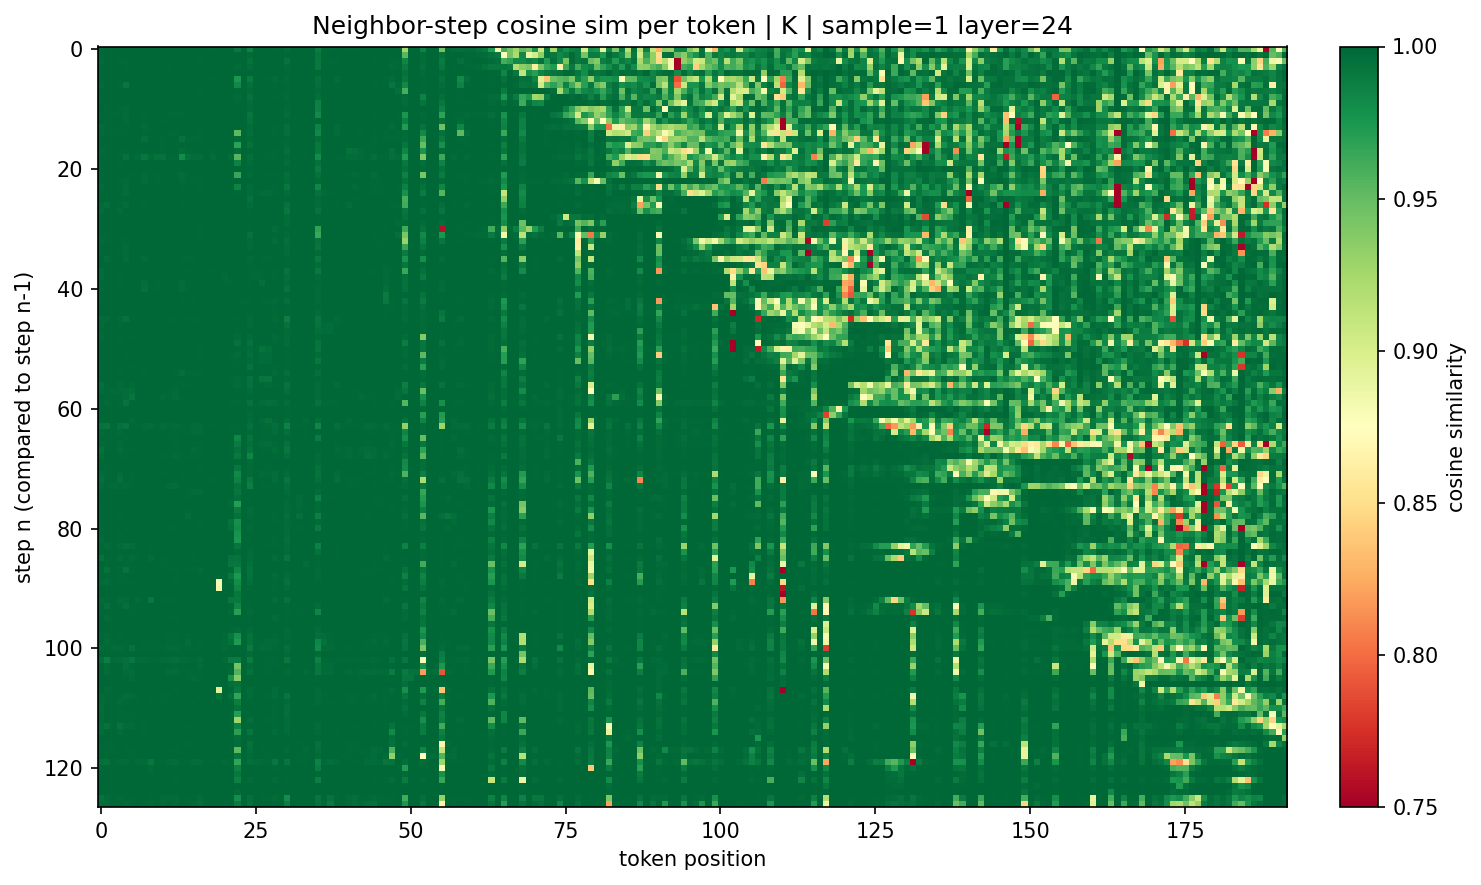

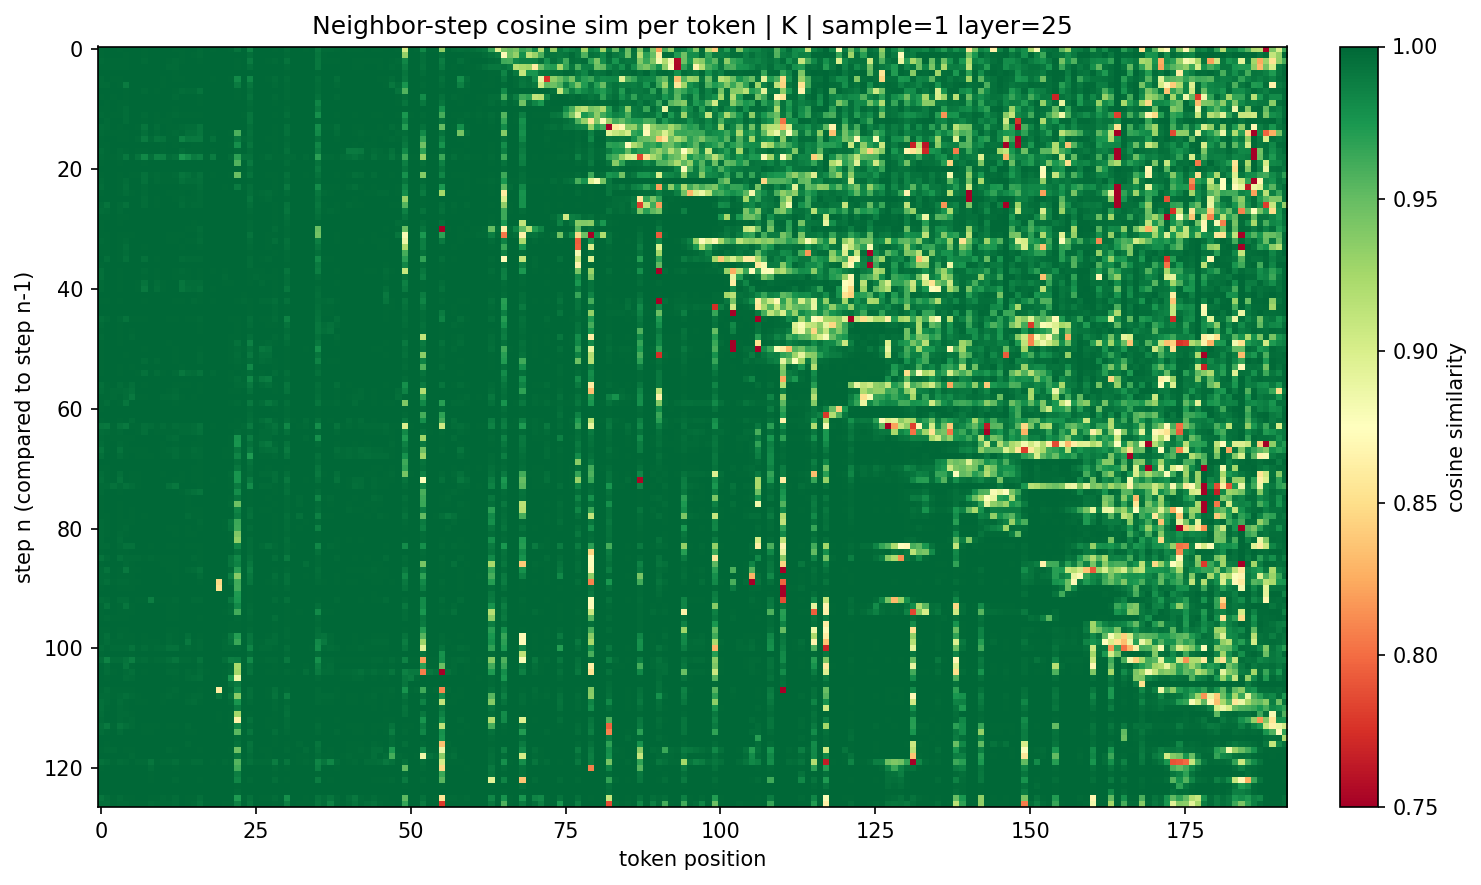

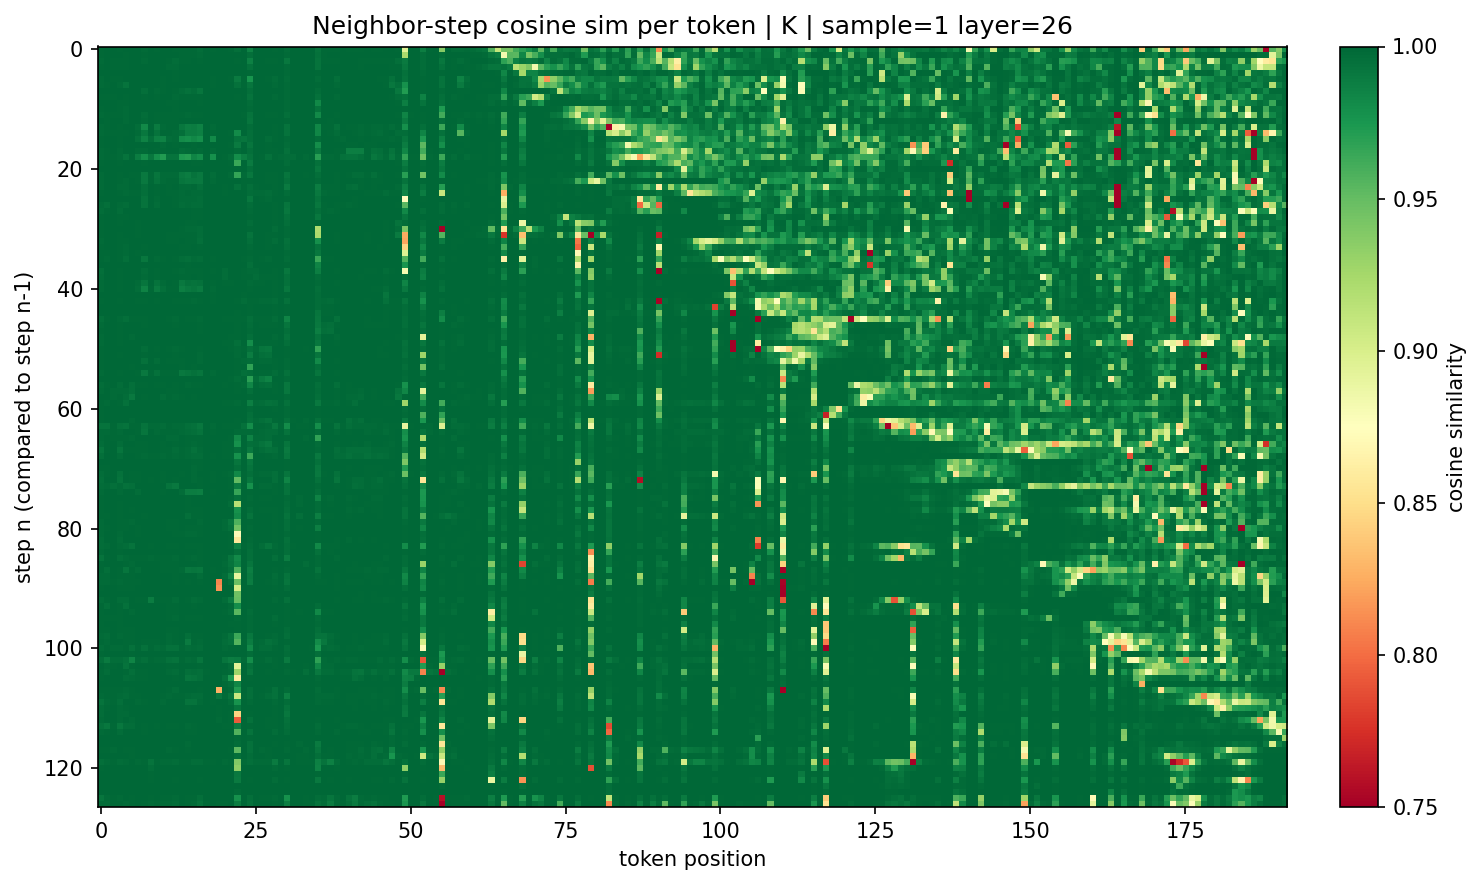

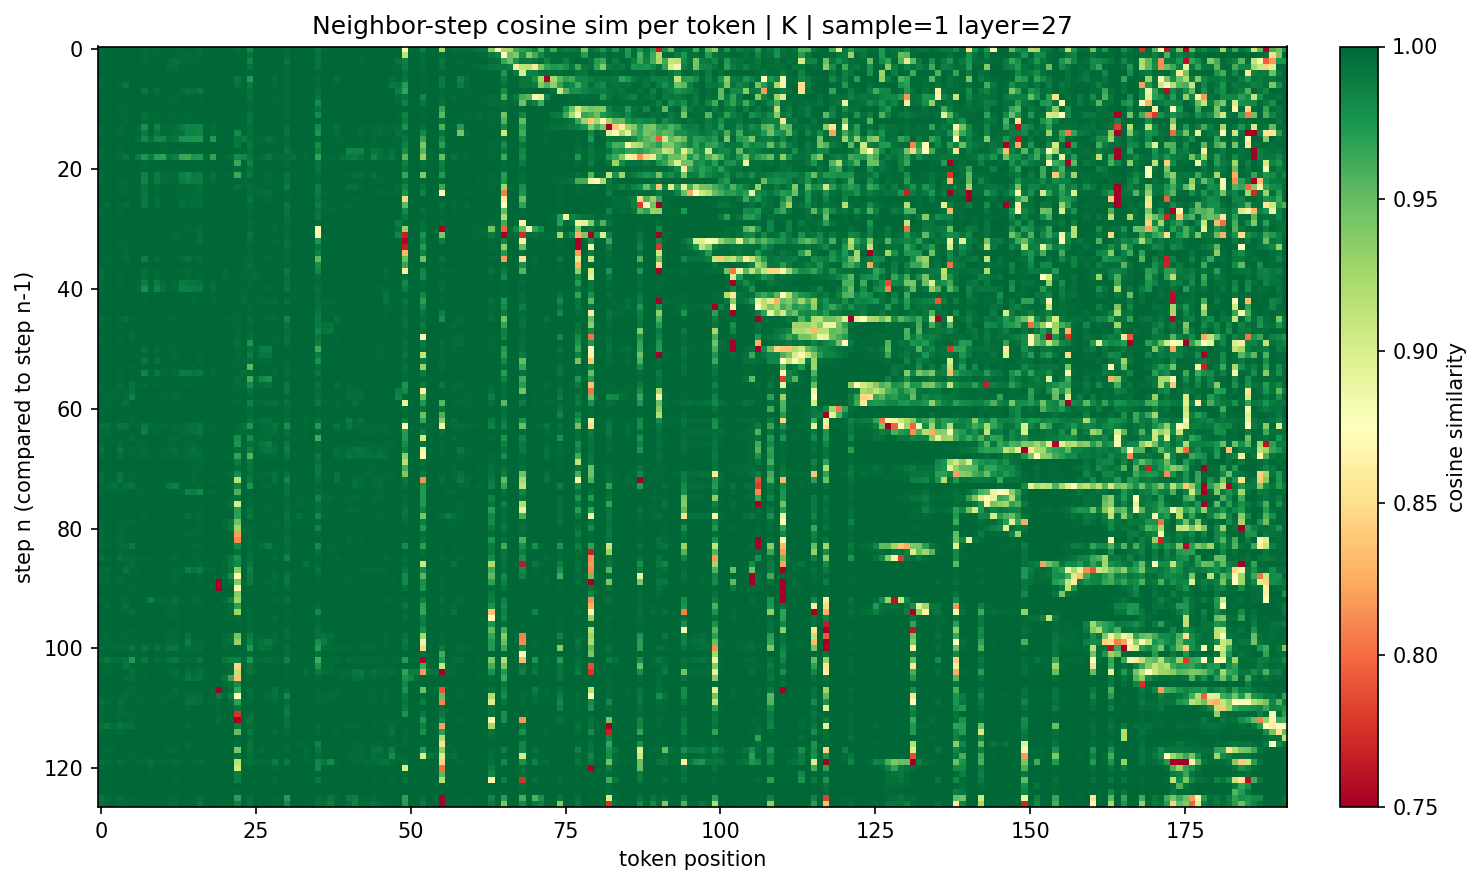

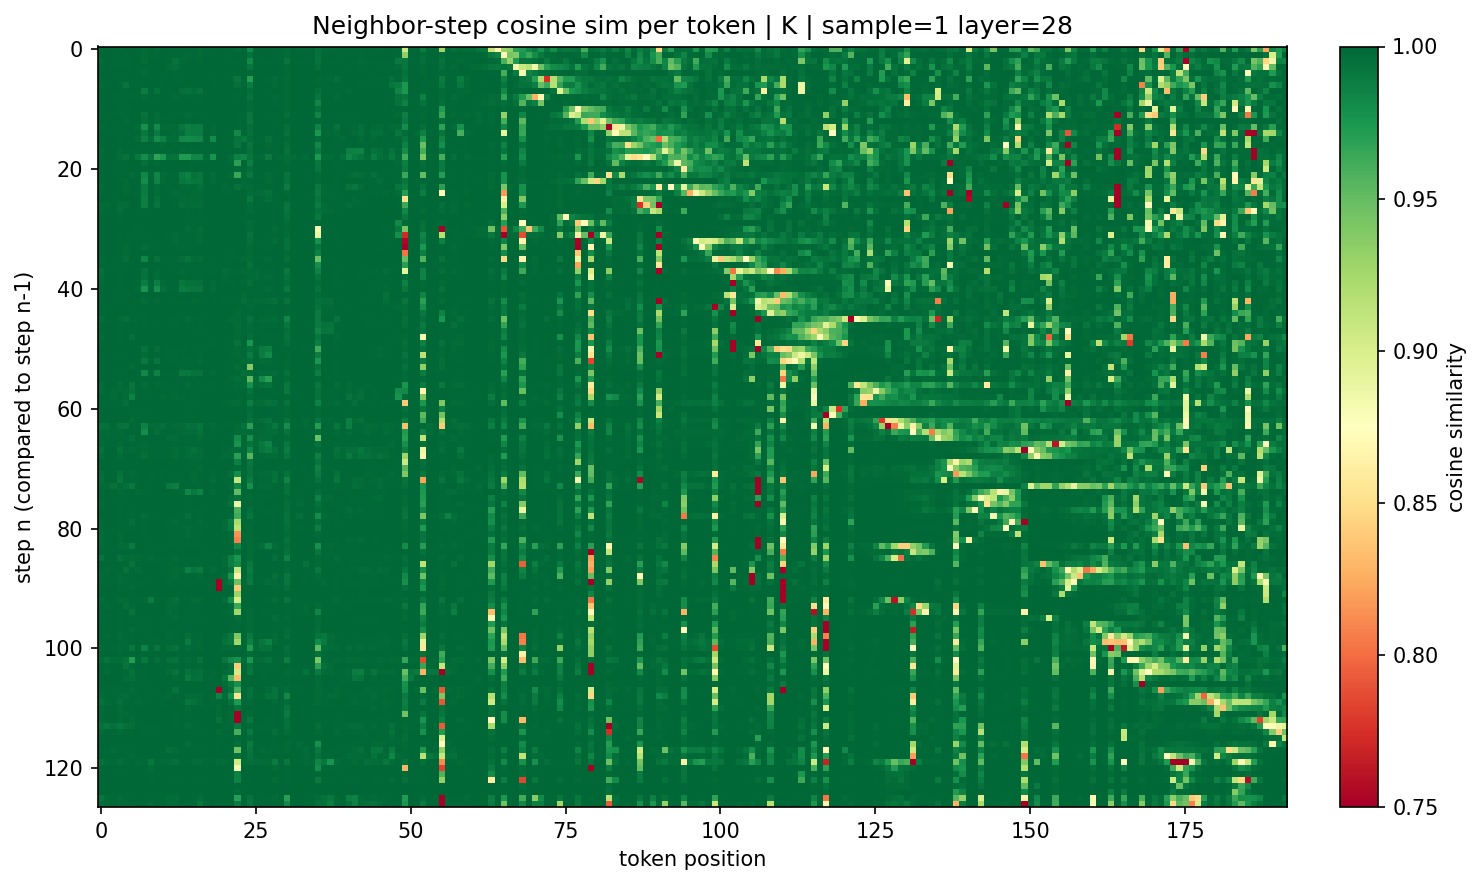

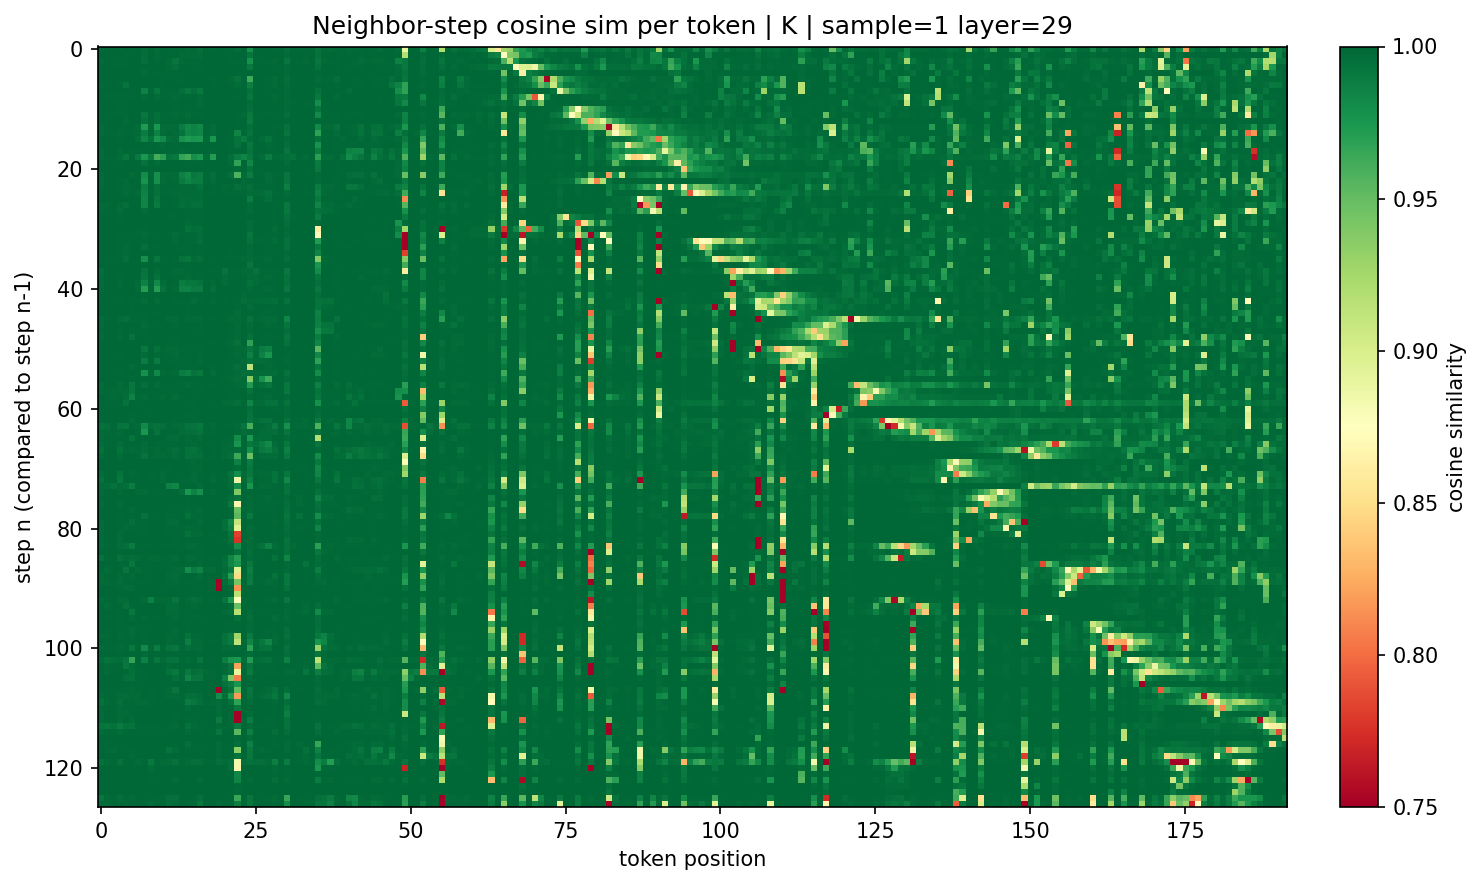

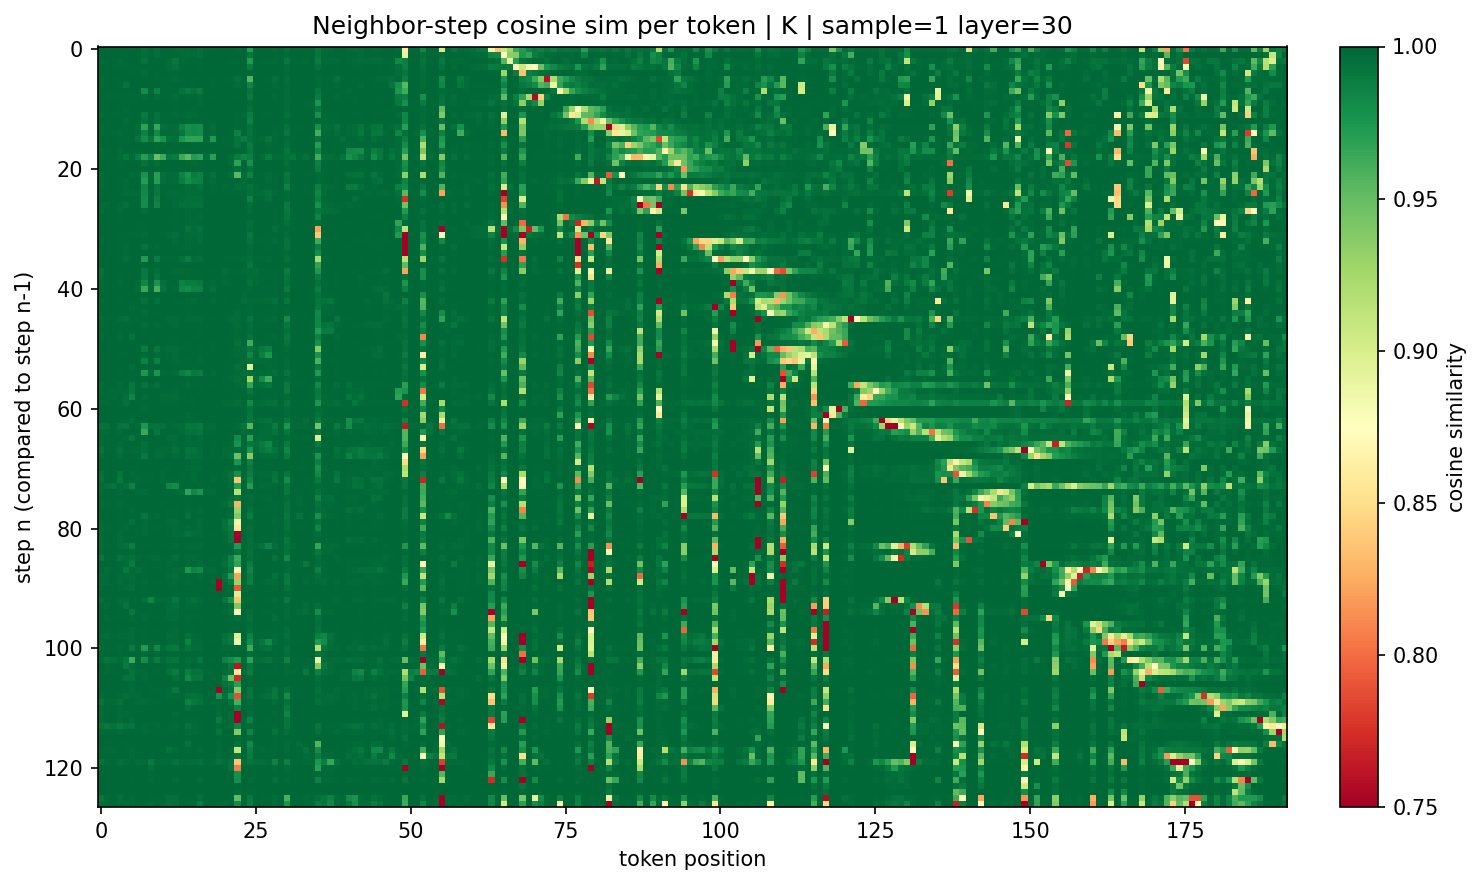

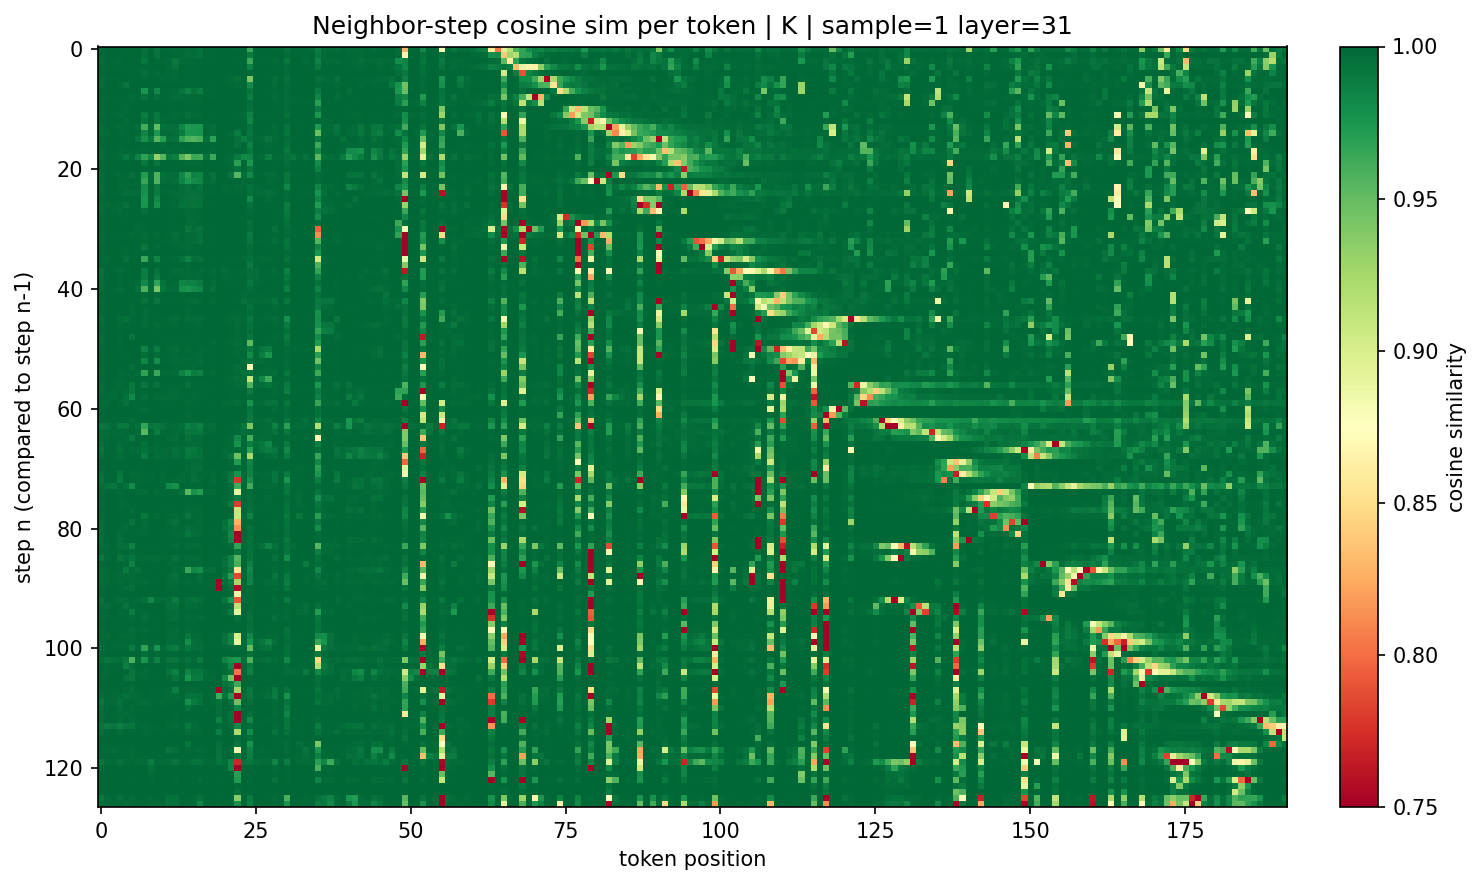

In [7]:
# ---- usage ----
records_dir = "kv_states"
sample_id = 1
kind = "k"  # or "v"

for layer in range(24,32):

    sims = neighbor_step_similarity_heatmap(
        records_dir=records_dir,
        sample_id=sample_id,
        layer=layer,
        kind=kind,
        total_steps=128,
        block_size=32,
        block_id_base=0,   # matches your example naming
    )

    plot_token_vs_neighborstep_heatmap(
        sims,
        title=f"Neighbor-step cosine sim per token | {kind.upper()} | sample={sample_id} layer={layer}",
        savepath=f"neighborstep_{kind}_b{sample_id}_l{layer}.png",
        vmin=0.75, vmax=1.0
    )
# end